##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Probabilistic principal components analysis (PCA) is a
dimensionality reduction technique that
analyzes data via a lower dimensional latent space
([Tipping and Bishop 1999](#1)). It is often
used when there are missing values in the data or for multidimensional
scaling.

## Imports

In [2]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

## The Model

Consider a data set $\mathbf{X} = \{\mathbf{x}_n\}$ of $N$ data
points, where each data point is $D$-dimensional, $\mathbf{x}_n \in
\mathbb{R}^D$. We aim to represent each $\mathbf{x}_n$ under a latent
variable $\mathbf{z}_n \in \mathbb{R}^K$ with lower dimension, $K <
D$. The set of principal axes $\mathbf{W}$ relates the latent variables to
the data.

Specifically, we assume that each latent variable is normally distributed,

\begin{equation*}
\mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}).
\end{equation*}

The corresponding data point is generated via a projection,

\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}),
\end{equation*}

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as
the principal axes. In probabilistic PCA, we are typically interested in
estimating the principal axes $\mathbf{W}$ and the noise term
$\sigma^2$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the
latent variable, the distribution of each data point is

\begin{equation*}
\mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^\top + \sigma^2\mathbf{I}).
\end{equation*}

Classical PCA is the specific case of probabilistic PCA when the
covariance of the noise becomes infinitesimally small, $\sigma^2 \to 0$.

We set up our model below. In our analysis, we assume $\sigma$ is known, and
instead of point estimating $\mathbf{W}$ as a model parameter, we
place a prior over it in order to infer a distribution over principal
axes. We'll express the model as a TFP JointDistribution, specifically, we'll
use [JointDistributionCoroutine](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionCoroutine).

In [3]:
Root = tfd.JointDistributionCoroutine.Root
def probabilistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
  w = yield Root(tfd.Independent(
      tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=2.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
  z = yield Root(tfd.Independent(
      tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
  x = yield tfd.Independent(tfd.Normal(
      loc=tf.matmul(w, z),
      scale=stddv_datapoints,
      name="x"), reinterpreted_batch_ndims=2)

In [4]:
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

concrete_ppca_model = functools.partial(probabilistic_pca,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model = tfd.JointDistributionCoroutine(concrete_ppca_model)

## The Data

We can use the model to generate data by sampling from the joint prior distribution.

In [5]:
actual_w, actual_z, x_train = model.sample()

print("Principal axes:")
print(actual_w)

Principal axes:
tf.Tensor(
[[4.286984 ]
 [1.8413343]], shape=(2, 1), dtype=float32)


We visualize the dataset.

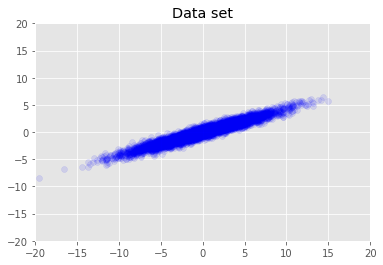

In [6]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-20, 20, -20, 20])
plt.title("Data set")
plt.show()

## Maximum a Posteriori Inference

We first search for the point estimate of latent variables that maximizes the posterior probability density. This is known as maximum a posteriori (MAP) inference, and is done by calculating the values of $\mathbf{W}$ and $\mathbf{Z}$ that maximise the posterior density $p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X}) \propto p(\mathbf{W}, \mathbf{Z}, \mathbf{X})$.


In [7]:
w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

target_log_prob_fn = lambda w, z: model.log_prob((w, z, x_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(w, z),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=200)

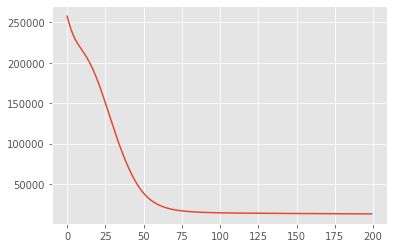

In [8]:
plt.plot(losses)

We can use the model to sample data for the inferred values for $\mathbf{W}$ and $\mathbf{Z}$, and compare to the actual dataset we conditioned on.

MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[3.5709004],
       [1.5516726]], dtype=float32)>


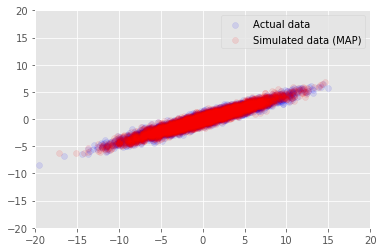

In [9]:
print("MAP-estimated axes:")
print(w)

_, _, x_generated = model.sample(value=(w, z, None))

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

## Variational Inference

MAP can be used to find the mode (or one of the modes) of the posterior distribution, but does not provide any other insights about it. We next use variational inference, where the posterior distribtion $p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X})$ is approximated using a variational distribution $q(\mathbf{W}, \mathbf{Z})$ parametrised by $\boldsymbol{\lambda}$. The aim is to find the variational parameters $\boldsymbol{\lambda}$ that _minimize_ the KL divergence between q and the posterior, $\mathrm{KL}(q(\mathbf{W}, \mathbf{Z}) \mid\mid p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X}))$, or equivalently, that _maximize_ the evidence lower bound, $\mathbb{E}_{q(\mathbf{W},\mathbf{Z};\boldsymbol{\lambda})}\left[ \log p(\mathbf{W},\mathbf{Z},\mathbf{X}) - \log q(\mathbf{W},\mathbf{Z}; \boldsymbol{\lambda}) \right]$.


In [10]:
qw_mean = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
qz_mean = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([data_dim, latent_dim]), dtype=tf.float32))
qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, num_datapoints]), dtype=tf.float32))
def factored_normal_variational_model():
  qw = yield Root(tfd.Independent(tfd.Normal(
      loc=qw_mean, scale=qw_stddv, name="qw"), reinterpreted_batch_ndims=2))
  qz = yield Root(tfd.Independent(tfd.Normal(
      loc=qz_mean, scale=qz_stddv, name="qz"), reinterpreted_batch_ndims=2))

surrogate_posterior = tfd.JointDistributionCoroutine(
    factored_normal_variational_model)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

Inferred axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[3.5591626],
       [1.5642134]], dtype=float32)>
Standard Deviation:
tf.Tensor(
[[0.01814996]
 [0.01814996]], shape=(2, 1), dtype=float32)


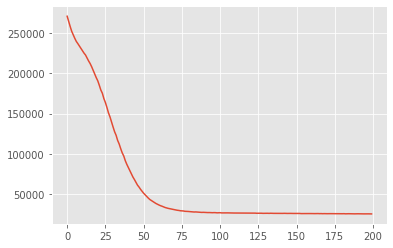

In [11]:
print("Inferred axes:")
print(qw_mean)
print("Standard Deviation:")
print(qw_stddv)

plt.plot(losses)
plt.show()

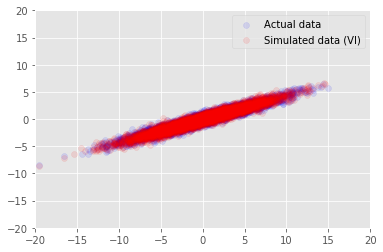

In [12]:
posterior_samples = surrogate_posterior.sample(50)
_, _, x_generated = model.sample(value=(posterior_samples))

# It's a pain to plot all 5000 points for each of our 50 posterior samples, so
# let's subsample to get the gist of the distribution.
x_generated = tf.reshape(tf.transpose(x_generated, [1, 0, 2]), (2, -1))[:, ::47]

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

#### References

<a name='1'></a>[1]: Michael E. Tipping and Christopher M. Bishop. Probabilistic principal component analysis. _Journal of the Royal Statistical Society: Series B (Statistical Methodology)_, 61(3): 611-622, 1999.